In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
from common import *
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.random_projection import GaussianRandomProjection

In [3]:
np.random.seed(0)

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
# Dataset Phone Price
x_train, x_test, y_train, y_test = read_dataset_income(path_to_file="../Data/dataset1/income_evaluation.csv")
x_train.head()

,age,workclass,education,marital-status,occupation,race,sex,hours-per-week,native-country
12132,72,4,11,6,1,4,0,40,39
24787,58,0,11,2,0,2,1,30,39
5923,42,4,11,2,3,4,1,40,39
3464,31,4,9,2,1,4,1,50,39
30739,36,4,9,0,10,4,0,50,39


In [6]:
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)

In [10]:
rc_errors = {}
for dim in range(2, 20):
    grp = GaussianRandomProjection(n_components=dim, random_state=0)
    x_prime = grp.fit_transform(x_train_scaled)
    
    # reconstruction
    A = np.linalg.pinv(grp.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(x_train.values, reconstructed)    
    rc_errors[dim] = rc_err

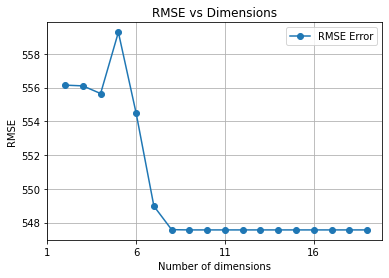

In [11]:
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), 'o-')
plt.title("RMSE vs Dimensions")
plt.xlabel("Number of dimensions")
plt.ylabel("RMSE")
plt.grid()
plt.legend(["RMSE Error"])
plt.xticks(np.arange(1, len(rc_errors), 5))
plt.show()

In [14]:
comp = 8
grp = GaussianRandomProjection(n_components=comp, random_state=0)
grp_result = grp.fit_transform(x_train_scaled)
for i in range(comp):
    field_name = "grp-"+str(i)
    x_train[f"grp-{i}"] = grp_result[:,i]
y_train.head()

,income
12132,0
24787,0
5923,0
3464,1
30739,0


<AxesSubplot:xlabel='grp-0', ylabel='grp-1'>

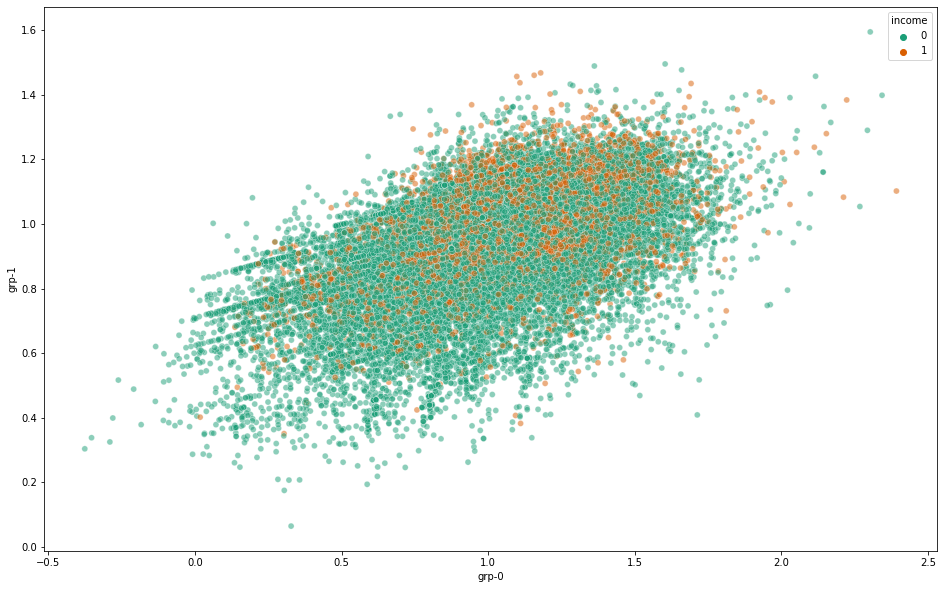

In [16]:
x_train['income'] = y_train['income']
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="grp-0", y="grp-1",
    hue="income",
    palette=sns.color_palette("Dark2", 2),
    data=x_train,
    legend="full",
    alpha=0.5
)

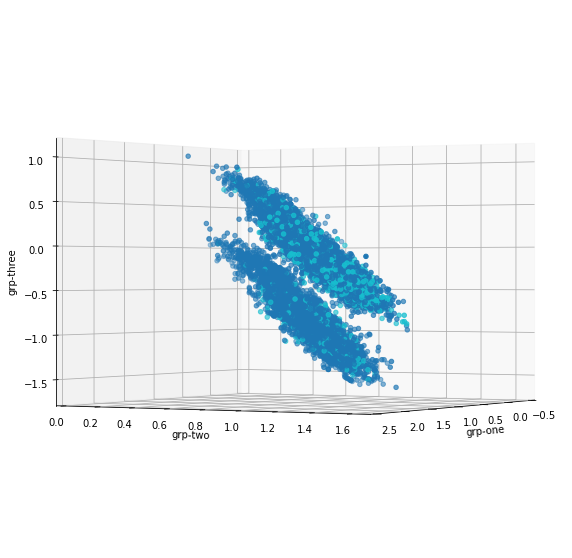

In [30]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=x_train["grp-0"], 
    ys=x_train["grp-1"], 
    zs=x_train["grp-2"], 
    c=x_train["income"], 
    cmap='tab10'
)
ax.set_xlabel('grp-one')
ax.set_ylabel('grp-two')
ax.set_zlabel('grp-three')
ax.view_init(0, 30)
plt.show()

In [37]:
# KMeans
s = {}
h = {}
clusters = range(2, 10)
for cluster in clusters:
    print(cluster)
    start_time = time.time()
    print(f"Start time: {start_time}")
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=100, random_state=0, n_jobs=-1, precompute_distances=True).fit(grp_result)
    label = kmeans.labels_
    s[cluster] = silhouette_score(grp_result, label, metric='euclidean')
    h[cluster] = homogeneity_score(y_train['income'].values, label)
    print(f"Cluster: {cluster}, Time: {time.time() - start_time}")

2
Start time: 1617577025.9430685
Cluster: 2, Time: 21.64172387123108
3
Start time: 1617577047.584994
Cluster: 3, Time: 29.482283115386963
4
Start time: 1617577077.0674722
Cluster: 4, Time: 30.65459680557251
5
Start time: 1617577107.7222707
Cluster: 5, Time: 31.9829204082489
6
Start time: 1617577139.7054088
Cluster: 6, Time: 34.74287748336792
7
Start time: 1617577174.4489155
Cluster: 7, Time: 47.15399932861328
8
Start time: 1617577221.603127
Cluster: 8, Time: 37.42167782783508
9
Start time: 1617577259.0250125
Cluster: 9, Time: 43.053417682647705


In [39]:
sdf = pd.DataFrame(list(s.values()), columns=['Silhouette'])
sdf['Homogeneity'] = pd.DataFrame(list(h.values()))

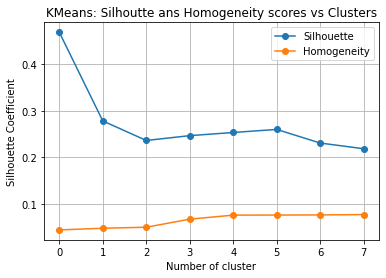

In [43]:
plt.figure()
plt.plot(sdf, 'o-')
plt.title("KMeans: Silhoutte ans Homogeneity scores vs Clusters")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.legend(sdf.columns)
plt.xticks(range(sdf.shape[0]))
plt.show()

In [44]:
# EM 
s_EM = {}
h_EM = {}
log_likelihood_EM = {}
clusters = range(2, 10)
for cluster in clusters:
    print(cluster)
    start_time = time.time()
    print(f"Start time: {start_time}")
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=0, n_init=50).fit(grp_result)
    label = gmm.predict(grp_result)
    s_EM[cluster] = silhouette_score(grp_result, label, metric='euclidean')
    h_EM[cluster] = homogeneity_score(y_train['income'].values, label)
    log_likelihood_EM[cluster] = gmm.score(grp_result)
    print(f"Cluster: {cluster}, Time: {time.time() - start_time}")

2
Start time: 1617577447.1947658
Cluster: 2, Time: 34.604920864105225
3
Start time: 1617577481.800377
Cluster: 3, Time: 63.47384023666382
4
Start time: 1617577545.2746441
Cluster: 4, Time: 64.13166117668152
5
Start time: 1617577609.4066916
Cluster: 5, Time: 75.74643516540527
6
Start time: 1617577685.1535099
Cluster: 6, Time: 101.52194356918335
7
Start time: 1617577786.675661
Cluster: 7, Time: 101.9797134399414
8
Start time: 1617577888.655584
Cluster: 8, Time: 115.07376909255981
9
Start time: 1617578003.7297661
Cluster: 9, Time: 138.29875206947327


In [53]:
gdf = pd.DataFrame(list(s_EM.values()), columns=['Silhouette'])
gdf['Homogeneity'] = pd.DataFrame(list(h_EM.values()))
gdf['Likelihood'] = pd.DataFrame(list(log_likelihood_EM.values()))

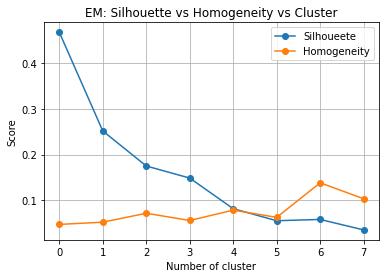

In [60]:
plt.figure()
plt.title(f'EM: Silhouette vs Homogeneity vs Cluster')
plt.plot(gdf[['Silhouette', 'Homogeneity']], 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("Score")
plt.grid()
plt.legend(['Silhoueete', 'Homogeneity'])
plt.show()

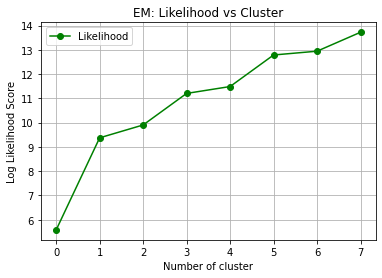

In [59]:
plt.figure()
plt.title(f"EM: Likelihood vs Cluster")
plt.plot(gdf[['Likelihood']], 'o-', color="green")
plt.xlabel("Number of cluster")
plt.ylabel("Log Likelihood Score")
plt.grid()
plt.legend(['Likelihood'])
plt.show()

In [48]:
nn = MLPClassifier()
nn.fit(grp_result, y_train['income'].values)

MLPClassifier()

In [49]:
y_pred = nn.predict(grp_result)
accuracy = accuracy_score(y_train, y_pred)
print(accuracy)
print(classification_report(y_train, y_pred))

0.8038237100737101
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     19803
           1       0.61      0.49      0.54      6245

    accuracy                           0.80     26048
   macro avg       0.73      0.70      0.71     26048
weighted avg       0.79      0.80      0.80     26048

